# The barometer data and location data from Kafka are read and processed in this notebook

### **Subscribe to Kafka Topic and Read Barometer Data Stream**

This step outlines subscribing to a Kafka topic and reading the barometer data stream for further processing.

In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Topic subscriben
df_barometer = spark\
    .readStream\
    .format('kafka')\
    .option('kafka.bootstrap.servers', 'localhost:9092')\
    .option('subscribe', 'barometer')\
    .option("startingOffsets", "earliest")\
    .load()
df_barometer.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### **Define Schema for Barometer Data**

This step defines the schema for parsing the barometer data, specifying the structure and data types for fields like `time`, `relativeAltitude`, and `pressure`.


In [2]:
schema = StructType([
    StructField("time", StringType(), True),
    StructField("values", StructType([
        StructField("relativeAltitude", StringType(), True),
        StructField("pressure", StringType(), True)
    ]))
])

### **Parse and Transform Barometer Data**

This step involves parsing the raw Kafka stream data using the defined schema and transforming it into a structured format for further processing:
- **Parsing JSON**: The raw Kafka `value` is parsed as JSON using the predefined schema.
- **Selecting Fields**: Key fields like `time`, `pressure`, and `relativeAltitude` are extracted and appropriately cast to their desired types (e.g., `float`).
- **Timestamp Transformation**: The `time` field is converted from nanoseconds to a proper `timestamp` format for easier time-based operations.


In [3]:
df_barometer_parsed = df_barometer.selectExpr("CAST(value AS STRING) AS json_string") \
    .select(from_json(col("json_string"), schema).alias("data"))

df_barometer_parsed = df_barometer_parsed.select(
    col("data.time").alias("timestamp"),
    col("data.values.pressure").cast("float").alias("pressure_hPa"),
    col("data.values.relativeAltitude").cast("float").alias("relative_altitude")
)

df_barometer_parsed = df_barometer_parsed.withColumn("timestamp", (col("timestamp").cast("long") / 1e9).cast("timestamp"))

df_barometer_parsed.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- pressure_hPa: float (nullable = true)
 |-- relative_altitude: float (nullable = true)



### **Aggregate Barometer Data with Sliding Windows**

This step aggregates the parsed barometer data over sliding time windows to calculate meaningful metrics:
- **Watermarking**: Sets a watermark of 1 minute to handle late-arriving data.
- **Windowing**: Groups the data into 30-second time windows for aggregation.
- **Aggregation**: Calculates the maximum (`max_pressure`) and minimum (`min_pressure`) pressure values for each window.
- **Altitude Change Calculation**: Computes the altitude change.

In [4]:
windowed_barometer = df_barometer_parsed\
    .withWatermark("timestamp", "1 minutes")\
    .groupBy(
        window(col("timestamp"), "30 seconds")
    )\
    .agg(
        max("pressure_hPa").alias("max_pressure"),
        min("pressure_hPa").alias("min_pressure")
    )\
    .withColumn("altitude_change", (col("min_pressure") - col("max_pressure")) * -8)

### **Select and Format Windowed Barometer Data**

This step extracts and formats the key columns from the windowed aggregation for further use:
- **Select Window Information**: Extracts the `start` and `end` times of each window and renames them to `start_time` and `end_time`.
- **Select Altitude Change**: Includes the calculated `altitude_change` metric for each window.

The resulting DataFrame contains:
- `start_time`: The start time of the aggregation window.
- `end_time`: The end time of the aggregation window.
- `altitude_change`: The calculated change in altitude for the window.

In [5]:
windowed_barometer = windowed_barometer.select(
    col("window.start").alias("start_time"),
    col("window.end").alias("end_time"),
    col("altitude_change")
)

### **Write Barometer Data to Memory Table**

This step writes the processed barometer data into a memory table named `barometer` for further querying.

In [6]:
query = windowed_barometer.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("barometer") \
    .start()

### **Query Processed Barometer Data**

This step retrieves the processed barometer data from the memory table and displays it, ordered by `start_time`.

In [8]:
result = spark.sql("SELECT * FROM barometer ORDER BY start_time")
result.show()

+-------------------+-------------------+---------------+
|         start_time|           end_time|altitude_change|
+-------------------+-------------------+---------------+
|2025-01-22 18:43:00|2025-01-22 18:43:30|      1.7827148|
|2025-01-22 18:43:30|2025-01-22 18:44:00|      1.9423828|
|2025-01-22 18:44:00|2025-01-22 18:44:30|      1.5107422|
|2025-01-22 18:44:30|2025-01-22 18:45:00|      0.7548828|
|2025-01-22 18:45:00|2025-01-22 18:45:30|      1.9389648|
|2025-01-22 18:45:30|2025-01-22 18:46:00|      2.1777344|
|2025-01-22 18:46:00|2025-01-22 18:46:30|       1.543457|
|2025-01-22 18:46:30|2025-01-22 18:47:00|      2.6298828|
|2025-01-22 18:47:00|2025-01-22 18:47:30|      1.4018555|
|2025-01-22 18:47:30|2025-01-22 18:48:00|      1.2158203|
|2025-01-22 18:48:00|2025-01-22 18:48:30|      1.2021484|
|2025-01-22 18:48:30|2025-01-22 18:49:00|      1.2373047|
|2025-01-22 18:49:00|2025-01-22 18:49:30|      3.2792969|
|2025-01-22 18:49:30|2025-01-22 18:50:00|      2.7719727|
|2025-01-22 18

### **Visualize Altitude Changes**

This step visualizes the altitude changes over time using a line plot:
- **Data Conversion**: Converts the Spark DataFrame to a Pandas DataFrame for visualization.
- **Plotting**:
  - `start_time` is used as the x-axis to represent the time windows.
  - `altitude_change` is plotted on the y-axis to show altitude variations.
  - The plot includes markers for better visibility and a grid for readability.
- **Title and Labels**: Clearly label the axes and provide a title for the plot.

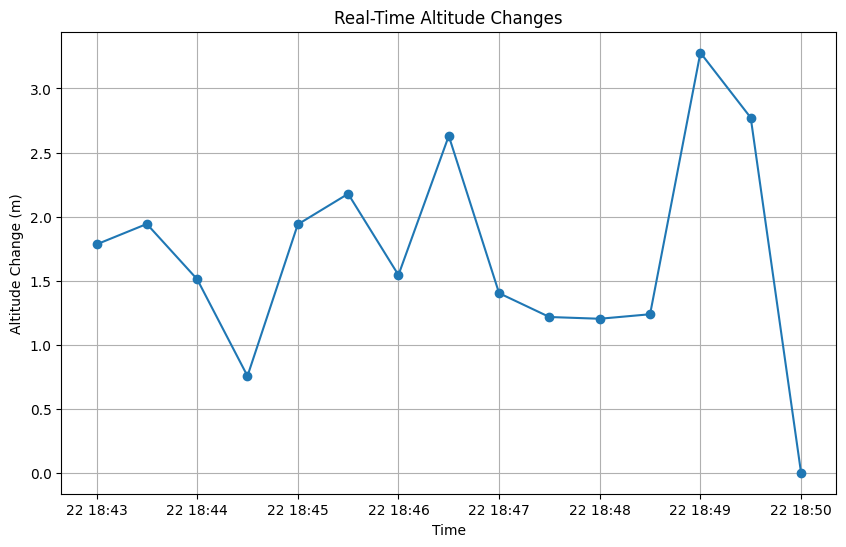

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

altitude_df = result.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(altitude_df['start_time'], altitude_df['altitude_change'], marker='o')
plt.xlabel('Time')
plt.ylabel('Altitude Change (m)')
plt.title('Real-Time Altitude Changes')
plt.grid()
plt.show()

### **Subscribe to Kafka Location Topic**

This step subscribes to the `location` Kafka topic and reads the incoming data stream for further processing.

In [10]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Topic subscriben
df_location = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "location") \
    .option("startingOffsets", "earliest") \
    .load()
df_location.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### **Define Schema for Location Data**

This step defines the schema for parsing the location data, including:
- `time`: The timestamp of the data.
- `values`: A nested structure containing `latitude` and `longitude`.

In [11]:
schema = StructType([
    StructField("time", StringType(), True),
    StructField("values", StructType([
        StructField("latitude", StringType(), True),
        StructField("longitude", StringType(), True)
    ]))
])

### **Parse and Transform Location Data**

This step parses the JSON location data from the Kafka stream and transforms it into a structured format with `timestamp`, `latitude`, and `longitude`.

In [12]:
df_location_parsed = df_location.selectExpr("CAST(value AS STRING) AS json_string") \
    .select(from_json(col("json_string"), schema).alias("data")).select("data.time", "data.values.latitude", "data.values.longitude")

df_location_parsed = df_location_parsed.select(
    col("time").alias("timestamp"),
    col("latitude"),
    col("longitude")
)

df_location_parsed = df_location_parsed.withColumn("timestamp", (col("timestamp").cast("long") / 1e9).cast("timestamp"))

df_location_parsed.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



### **Aggregate Location Data with Sliding Windows**

This step aggregates the location data over 30-second sliding windows, capturing the most recent `latitude` and `longitude` for each window.

In [13]:
windowed_location = df_location_parsed\
    .withWatermark("timestamp", "1 minutes")\
    .groupBy(
        window(col("timestamp"), "30 seconds")
    )\
    .agg(
        last("latitude").alias("latitude"),
        last("longitude").alias("longitude"),
    )

### **Select and Format Windowed Location Data**

This step extracts and formats key columns, including `start_time`, `end_time`, `latitude`, and `longitude`, from the windowed location data.

In [14]:
windowed_location = windowed_location.select(
    col("window.start").alias("start_time"),
    col("window.end").alias("end_time"),
    col("latitude"),
    col("longitude")
)

### **Write Windowed Location Data to Memory**

This step writes the windowed location data into a memory table named `location` for further querying and analysis.

In [15]:
query = windowed_location.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("location") \
    .start()

### **Query and Display Windowed Location Data**

This step retrieves the windowed location data from the memory table `location`, ordered by `start_time` in descending order, and displays the results.

In [17]:
result = spark.sql("SELECT * FROM location ORDER BY start_time")
result.show()

+-------------------+-------------------+------------------+------------------+
|         start_time|           end_time|          latitude|         longitude|
+-------------------+-------------------+------------------+------------------+
|2025-01-22 18:43:00|2025-01-22 18:43:30| 46.65400333560591|  7.87383784713366|
|2025-01-22 18:43:30|2025-01-22 18:44:00|46.654231817388414| 7.873970706807959|
|2025-01-22 18:44:00|2025-01-22 18:44:30| 46.65455985360713| 7.873858911973599|
|2025-01-22 18:44:30|2025-01-22 18:45:00| 46.65492900068599|7.8736650198660145|
|2025-01-22 18:45:00|2025-01-22 18:45:30| 46.65522736891566|  7.87354503750548|
|2025-01-22 18:45:30|2025-01-22 18:46:00|  46.6555052650942| 7.873512642154449|
|2025-01-22 18:46:00|2025-01-22 18:46:30| 46.65571314699889| 7.873077303453392|
|2025-01-22 18:46:30|2025-01-22 18:47:00| 46.65562236994982|7.8725598133291275|
|2025-01-22 18:47:00|2025-01-22 18:47:30|46.655668412519084| 7.871994705235934|
|2025-01-22 18:47:30|2025-01-22 18:48:00

### **Stream Processed Data to Redis**

This step writes processed location and barometer data into Redis for storage and future access:
- **`write_to_redis` Function**:
  - Writes location data (`latitude` and `longitude`) to Redis under keys formatted as `location:{start_time}_{end_time}`.
  - Writes barometer data (`altitude_change`) to Redis under keys formatted as `barometer:{start_time}_{end_time}`.
- **Streaming Queries**:
  - `query_location`: Streams windowed location data to Redis.
  - `query_barometer`: Streams windowed barometer data to Redis.
- **Termination Handling**:
  - Both queries are set to run continuously and wait for termination.

In [18]:
from redis import Redis

def write_to_redis(row):
    redis_client = Redis(host='localhost', port=6379, db=0)

    data = row.asDict()

    if 'latitude' in data and 'longitude' in data:
        location_key = f"location:{data['start_time']}_{data['end_time']}"
        redis_client.hset(location_key, mapping={
            "latitude": data['latitude'],
            "longitude": data['longitude'],
        })

    if 'altitude_change' in data:
        barometer_key = f"barometer:{data['start_time']}_{data['end_time']}"
        redis_client.hset(barometer_key, mapping={
            "altitude_change": data['altitude_change'],
        })

query_location = (
    windowed_location.writeStream
    .foreach(write_to_redis)
    .outputMode("update")
    .start()
)
query_barometer = (
    windowed_barometer.writeStream
    .foreach(write_to_redis)
    .outputMode("update")
    .start()
)

query_location.awaitTermination()
query_location.awaitTermination()

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### **Retrieve All Keys from Redis**

This step retrieves all keys stored in the Redis database:
- **Redis Scan**:
  - Uses the `scan` method to iteratively retrieve keys in batches of 10 to avoid performance issues with large datasets.
  - The cursor is used to keep track of the scanning position.
- **Key Decoding**:
  - Decodes the keys from bytes to strings for readability.
- **Output**:
  - Prints the list of all keys in Redis.
  - Displays the total number of keys retrieved.

In [19]:
from redis import Redis

redis_client = Redis(host='localhost', port=6379, db=0)

cursor = 0
all_keys = []

while True:
    cursor, keys = redis_client.scan(cursor=cursor, count=10)
    all_keys.extend(keys)
    if cursor == 0:
        break

print([key.decode('utf-8') for key in all_keys])
print(len(all_keys))

['barometer:2025-01-22 18:45:00_2025-01-22 18:45:30', 'location:2025-01-22 18:48:30_2025-01-22 18:49:00', 'location:2025-01-22 18:45:00_2025-01-22 18:45:30', 'barometer:2025-01-22 18:44:30_2025-01-22 18:45:00', 'barometer:2025-01-22 18:46:00_2025-01-22 18:46:30', 'barometer:2025-01-22 18:49:30_2025-01-22 18:50:00', 'barometer:2025-01-22 18:43:30_2025-01-22 18:44:00', 'barometer:2025-01-22 18:47:30_2025-01-22 18:48:00', 'location:2025-01-22 18:50:00_2025-01-22 18:50:30', 'location:2025-01-22 18:43:00_2025-01-22 18:43:30', 'barometer:2025-01-22 18:45:30_2025-01-22 18:46:00', 'location:2025-01-22 18:48:00_2025-01-22 18:48:30', 'barometer:2025-01-22 18:48:30_2025-01-22 18:49:00', 'location:2025-01-22 18:44:30_2025-01-22 18:45:00', 'barometer:2025-01-22 18:43:00_2025-01-22 18:43:30', 'barometer:2025-01-22 18:48:00_2025-01-22 18:48:30', 'barometer:2025-01-22 18:50:00_2025-01-22 18:50:30', 'location:2025-01-22 18:44:00_2025-01-22 18:44:30', 'location:2025-01-22 18:49:00_2025-01-22 18:49:30', 